In [1]:
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.lines import Line2D
import matplotlib as mpl
mpl.style.use('../plotting.mplstyle')
import json
import sys
sys.path.append('./../code/')
import population_parameters

In [2]:
# Retrive json file
with open('./../input/o1o2o3_mass_c_iid_mag_iid_tilt_powerlaw_redshift_result.json','r') as jf:
    plpeak_data = json.load(jf)

# Read out mass parameters
plpeak_alphas = np.array(plpeak_data['posterior']['content']['alpha'])
plpeak_mMaxs = np.array(plpeak_data['posterior']['content']['mmax'])
plpeak_mMins = np.array(plpeak_data['posterior']['content']['mmin'])
plpeak_fPeaks = np.array(plpeak_data['posterior']['content']['lam'])
plpeak_mu_m1s = np.array(plpeak_data['posterior']['content']['mpp'])
plpeak_sig_m1s = np.array(plpeak_data['posterior']['content']['sigpp'])
plpeak_delta_ms = np.array(plpeak_data['posterior']['content']['delta_m'])
plpeak_betas = np.array(plpeak_data['posterior']['content']['beta'])

# Read rate and redshift evolution parameters
plpeak_kappas = np.array(plpeak_data['posterior']['content']['lamb'])
plpeak_Rtot = np.array(plpeak_data['posterior']['content']['rate'])

# Read spin parameters
# Remember that `sigma_chi` as computed by gwpopulation is actually the *variance* of the spin magnitude distribution
default_mu_chi = np.array(plpeak_data['posterior']['content']['mu_chi'])
default_sig_chi = np.sqrt(np.array(plpeak_data['posterior']['content']['sigma_chi']))
default_sig_aligned = np.array(plpeak_data['posterior']['content']['sigma_spin'])
default_f_aligned = np.array(plpeak_data['posterior']['content']['xi_spin'])

# Construct and return dictionary
lvk_data = {
    'alpha':plpeak_alphas,
    'mMax':plpeak_mMaxs,
    'mMin':plpeak_mMins,
    'fPeak':plpeak_fPeaks,
    'mu_m1':plpeak_mu_m1s,
    'sig_m1':plpeak_sig_m1s,
    'delta_m':plpeak_delta_ms,
    'bq':plpeak_betas,
    'kappa':plpeak_kappas,
    'Rtot':plpeak_Rtot,
    'mu_chi':default_mu_chi,
    'sig_chi':default_sig_chi,
    'sig_cost':default_sig_aligned,
    'f_aligned':default_f_aligned
    }

In [3]:
def lvk_plpeak(alpha,mMax,mMin,fPeak,mu_m1,sig_m1,delta_m,kappa,R,z,npts=1000):

    """
    Helper function that computes the merger rate over a grid of primary masses and mass ratios, according to
    a PowerLaw+Peak mass model

    Inputs
    ------
    alpha : float
        Slope on the "power law" piece of the Power-Law+Peak primary mass model
    mMax : float
        Maximum black hole mass
    mMin : float
        Minimum black hole mass
    fPeak : float
        Fraction of primaries occupying the "peak" part of the Power-Law+Peak primary mass model
    mu_m1 : float
        Mean location of the primary mass peak
    sig_m1 : float
        Standard deviation of the primary mass peak
    delta_m : float
        Smoothing length over which the primary mass distribution "turns on" above `mMin`
    R : float
        Overall merger rate (integrated across masses) at `z=0`
    z : float
        Redshift at which to evaluate merger rate

    Returns
    -------
    ms : np.array
        Primary masses at which merger rate is evaluated
    dR_dm1 : np.array
        Array of merger rate densities `dR/dm1` defined at `ms` and `z`
    """
    
    # Define array of masses
    ms = np.linspace(2,100,npts)

    # Primary mass probability distribution
    # Start by defining normalized power-law and gaussian components
    pl = (1.-alpha)*ms**(-alpha)/(mMax**(1.-alpha) - mMin**(1.-alpha))
    pl[ms<mMin] = 0
    pl[ms>mMax] = 0
    peak = np.exp(-(ms-mu_m1)**2/(2.*sig_m1**2))/np.sqrt(2.*np.pi*sig_m1**2)

    # Identify masses at which smoothing will be applied
    smoothing = np.ones(ms.shape)
    to_smooth = (ms>mMin)*(ms<mMin+delta_m)

    # Then define and apply smoothing factor
    smoothing[to_smooth] = 1./(np.exp(delta_m/(ms[to_smooth]-mMin) + delta_m/(ms[to_smooth]-mMin-delta_m))+1.)
    smoothing[ms<mMin] = 0
    p_m1_unnormed = (fPeak*peak + (1.-fPeak)*pl)*smoothing

    # Normalize
    p_m1 = p_m1_unnormed/(np.sum(p_m1_unnormed)*(ms[1]-ms[0]))

    # Scale by total rate at z=0.2 and return
    dR_dm1 = R*(1.+z)**kappa*p_m1

    return ms,dR_dm1

In [4]:
nTraces = 1000
npts = 300
lvk_dRdms = np.zeros((nTraces,npts))
random_inds = np.random.choice(np.arange(lvk_data['alpha'].size),nTraces,replace=False)

for i in range(nTraces):

    ind = random_inds[i]
    lvk_ms,dRdm1 = lvk_plpeak(lvk_data['alpha'][ind],
                         lvk_data['mMax'][ind],
                         lvk_data['mMin'][ind],
                         lvk_data['fPeak'][ind],
                         lvk_data['mu_m1'][ind],
                         lvk_data['sig_m1'][ind],
                         lvk_data['delta_m'][ind],
                         lvk_data['kappa'][ind],
                         lvk_data['Rtot'][ind],
                         0.,
                         npts)

    lvk_dRdms[i,:] = dRdm1

/var/folders/b2/tcwq2bcs0214_0cxpktjl4t80000gn/T/ipykernel_57859/597127883.py:51: RuntimeWarning: overflow encountered in exp
  smoothing[to_smooth] = 1./(np.exp(delta_m/(ms[to_smooth]-mMin) + delta_m/(ms[to_smooth]-mMin-delta_m))+1.)


In [5]:
# Define hyperparameters describing mass distribution
R0 = population_parameters.R0
m_min = population_parameters.m_min
m_max = population_parameters.m_max
dm_min = population_parameters.dm_min
dm_max = population_parameters.dm_max
alpha = population_parameters.alpha_m
mu_peak = population_parameters.mu_peak
sig_peak = population_parameters.sig_peak
frac_peak = population_parameters.frac_peak
bq = population_parameters.bq

def our_plpeak(alpha,mMax,mMin,dmMax,dmMin,frac_peak,mu_peak,sig_peak,R,npts=1000):

    ms = np.linspace(2,100,npts)

    # Power law component in m1
    p_m1_pl = (1.+alpha)*ms**alpha/(100.**(1.+alpha) - 2.**(1.+alpha))

    # Gaussian component in m1
    p_m1_peak = np.exp(-(ms-mu_peak)**2/(2.*sig_peak**2))/np.sqrt(2.*np.pi*sig_peak**2)

    # Compute low- and high-mass filters
    low_filter = np.exp(-(ms-mMin)**2/(2.*dmMin**2))
    low_filter = np.where(ms<mMin,low_filter,1.)
    high_filter = np.exp(-(ms-mMax)**2/(2.*dmMax**2))
    high_filter = np.where(ms>mMax,high_filter,1.)

    # Apply filters to combined power-law and peak
    probs_m1 = (frac_peak*p_m1_peak + (1.-frac_peak)*p_m1_pl)*low_filter*high_filter
    
    # Normalize
    probs_m1 /= np.trapz(probs_m1,ms)
    dRdm = R*probs_m1
    
    return ms,dRdm

our_ms,our_dRdm = our_plpeak(alpha,m_max,m_min,dm_max,dm_min,frac_peak,mu_peak,sig_peak,R0,npts)

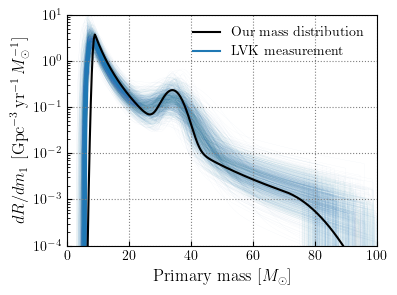

In [6]:
fig,ax = plt.subplots(figsize=(4,3))
ax.set_rasterization_zorder(2)

for i in range(nTraces):
    ax.plot(lvk_ms,lvk_dRdms[i,:],color='#1f78b4',alpha=0.1,lw=0.1,zorder=1)
    
ax.plot(our_ms,our_dRdm,color='black')

lines = [Line2D([0],[0],color='black'),Line2D([0], [0], color='#1f78b4')]
labels = ["Our mass distribution","LVK measurement"]
ax.legend(lines,labels)
    
ax.set_yscale('log')
ax.set_xlim(0,100)
ax.set_ylim(1e-4,10)
ax.set_xlabel(r'Primary mass [$M_\odot$]')
ax.set_ylabel(r'$dR/dm_1$ [$\mathrm{Gpc}^{-3}\,\mathrm{yr}^{-1}\,M_\odot^{-1}$]')

plt.savefig('figure_14.pdf',bbox_inches='tight',dpi=200)
plt.show()